Поскольку у pymc3 какие-то проблемы с theano, на Colab пришлось поставить dev версию через github.

In [14]:
!pip install git+https://github.com/pymc-devs/pymc3 numpyro numpy pandas matplotlib seaborn arviz scipy

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-n8csh6ai
  Running command git clone -q https://github.com/pymc-devs/pymc3 /tmp/pip-req-build-n8csh6ai
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pymc3: filename=pymc3-4.0-cp37-none-any.whl size=878963 sha256=9dd5a0be6853b051308ddcba6a061bd0b9d258caf8b00c042497814729b6eb18
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bvl6gmc/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3


In [15]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
sns.set()
from scipy import stats

In [17]:
import jax.numpy as jnp
import jax
from jax import random, vmap
from jax.scipy.special import logsumexp

In [18]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

Вспомним формулу Байеса:
$$
p(\theta | x) = \dfrac{p(x | \theta)p(\theta)}{p(x)}
$$

Простой дискретный пример.

В Небольшом пруду водятся караси и щуки, причём согласно поверью, в любой момент времени доля карасей в Небольшом пруду может равновероятно быть либо $1/3$, либо $2/3$ в зависимости от погодных условий. Исследовательница Авдотья вылавливает десять рыб подряд. Оказалось, что в полученной выборке шесть щук и четыре карася.

а) Найдите оценку максимального правдоподобия $\hat{p}_{c}$, рассуждая с позиций частотного подхода.

Ответ: $\hat{p}_{c} = 4/10$

б) Сделаем то же самое в рамках байесовского подхода. 

$$ 
p(\theta | y)  \propto p(y| \theta) \times p(\theta)
$$

$ p(\theta) = 1/2 $ (оба значения доли карасей равновероятны), $ p(y| \theta) = p^x \times (1-p)^{n-x}$. Посчитаем апостериорное распределение для обоих возможных значений $p$: 

In [19]:
p1 = (1/3) ** 4 * (2/3) ** 6 * (1/2)
p2 = (2/3) ** 4 * (1/3) ** 6 * (1/2)
print(f"Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет {p1/(p1+p2)}.")
print(f"Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет {p2/(p1+p2)}.")

Апостериорная вероятность того, что вероятность поймать карася 1/3, составляет 0.8.
Апостериорная вероятность того, что вероятность поймать карася 2/3, составляет 0.2.


Это вполне логично - 0.4 ближе к 1/3, чем к 2/3. 

#### Задание 1. Караси и щуки.

В Большом пруду водятся караси и щуки, причём согласно поверью, вероятность встретить карася равномерно распределена на отрезке от 0 до 1. Ловля рыбы в Большом пруду запрещена, поэтому исследовательница Авдотья решает провести численный эксперимент для вывода апостериорного распределения вероятности встретить карася.

Сгенерируйте выборку из из 100 наблюдений, каждое из которых является идентификатором того, является ли пойманная рыба карасём.

In [55]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.22


array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

1. Задайте вероятностную модель.

In [56]:
def model(y):
  p = numpyro.sample('share', dist.Uniform(0, 1))
  y_obs = numpyro.sample('obs', dist.Bernoulli(p), obs=y)

2. Оцените модель и получите приблизительное апостериорное распределение параметров.

In [57]:
kernel = NUTS(model) # NUTS sampler 
# 100 первых наблюдений будет выкинуто при оценке апостериорного распределения
# оставшиеся 500 наблюдений будут сохранены
mcmc = MCMC(kernel, 100, 1000)
mcmc.run(random.PRNGKey(123), y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:04<00:00, 261.82it/s, 3 steps of size 2.25e+00. acc. prob=0.76]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     share      0.23      0.04      0.22      0.16      0.30    618.17      1.00

Number of divergences: 0


In [58]:
print(f"Выборочное среднее апостериорного распределения: {samples_1['share'].mean()}.")

Выборочное среднее апостериорного распределения: 0.226618230342865.


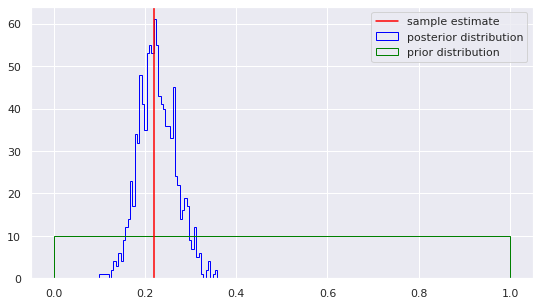

In [59]:
plt.figure(figsize=(9, 5));
plt.hist(samples_1['share'], bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');


У `numpyro` заметно сразу два минуса:
* Нельзя нарисовать динамику по цепям для генерируемого апостериорного распределения.
* Не считаются никакие статистики, которые говорили бы о сходимости апостериорного распределения. В этом плане `PyMC3` гораздо лучше.

Попробуем то же самое сделать через PyMC3, благо синтаксис похож.

In [66]:
ndraws = 1000
nburn = 100

with pm.Model() as model:
  p = pm.Uniform('p', lower=0, upper=1)
  y_obs = pm.Bernoulli('obs', p=p, observed=y)

  step = pm.NUTS()
  trace = pm.sample(# сколько наблюдений мы хотим сэмплировать
                    ndraws,
                    # сколько наблюдений мы хотим "сжечь"
                    tune=nburn, 
                    # удаляем ли мы "сжигаемые" набл-я из апостериорной выборки
                    discard_tuned_samples=True, 
                    # сэмплировщик
                    step=step, 
                    random_seed=np.random.seed(123),
                    # количество ядер, чтоб считать параллельно
                    cores=4,
                    # количество цепей Маркова
                    chains=4)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 5 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.9365673449428754, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9184345621528626, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.944928287087228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9483499098922673, but should be close to 0.8. Try to increase the number of tuning steps.


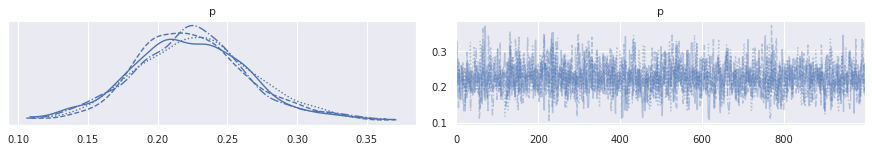

In [67]:
az.plot_trace(trace);

В `trace` есть много чего, при желании можно вытащить, например, выборку из апостериорного распределения для каждой цепи. 

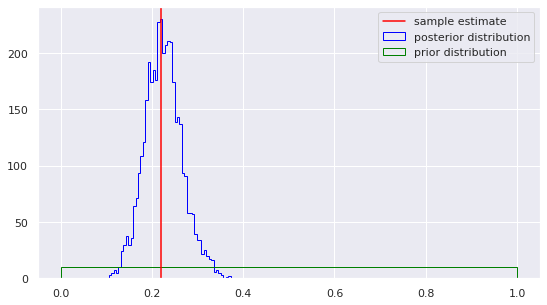

In [68]:
plt.figure(figsize=(9, 5));
plt.hist(np.array(trace.posterior.p).ravel(), bins=50, histtype='step', label='posterior distribution', color='blue');
plt.hist(np.linspace(0, 1, 500), bins=50, histtype='step', label='prior distribution', color='green');
plt.axvline(np.mean(y), color='red', label='sample estimate');
plt.legend(loc='best');

Попробуем вытащить характеристики апостериорного распределения:

In [69]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.225,0.041,0.144,0.304,0.001,0.001,1469.0,1732.0,1.0


In [70]:
print(f"Выборочное среднее апостериорного распределения: {np.array(trace.posterior.p).ravel().mean()}.")

Выборочное среднее апостериорного распределения: 0.224780519914549.


Посмотрим, удалились ли те наблюдения из апостериорного распределения, которые мы хотели сжечь. Если да, то shape у trace.posterior.p = (4, 1000).

In [72]:
np.array(trace.posterior.p).shape

(4, 1000)